In [5]:
import os
# ✅ 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ 2. Define paths
BASE_PATH = "/content/drive/MyDrive/ball detection"
DATASET_PATH = f"{BASE_PATH}/bat_dataset"
RUNS_PATH = f"{BASE_PATH}/runs"
os.makedirs(RUNS_PATH, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

# ✅ 3. Check dataset structure
import os
print("Dataset files:", os.listdir(DATASET_PATH))

# ✅ 4. Load the old trained model (ball-only)
from ultralytics import YOLO

BALL_MODEL_PATH = f"{BASE_PATH}/runs/cric_detect_train_bat_ball_sample2/weights/best.pt"
assert os.path.exists(BALL_MODEL_PATH), "❌ best.pt not found — check your runs folder"

# ✅ 5. Display dataset YAML content (for reference)
yaml_path = f"{DATASET_PATH}/data.yaml"
with open(yaml_path, "r") as f:
    print("Original YAML:\n", f.read())

Dataset files: ['data.yaml', 'README.roboflow.txt', 'README.dataset.txt', 'valid', 'test', 'train', 'data_filtered.yaml']
Original YAML:
 train: ../train/images
val: ../valid/images
test: ../test/images

nc: 5
names: ['ball', 'bat', 'batter', 'bowler', 'pad']

roboflow:
  workspace: players-kfdep
  project: cric_detect-0vwtp
  version: 7
  license: CC BY 4.0
  url: https://universe.roboflow.com/players-kfdep/cric_detect-0vwtp/dataset/7


In [7]:
# ✅ 6. Create a filtered YAML — only 'bat' and 'ball'
filtered_yaml = f"""
train: {DATASET_PATH}/train/images
val: {DATASET_PATH}/valid/images

nc: 2
names: ['ball', 'bat']
"""
yaml_filtered_path = f"{DATASET_PATH}/data_filtered.yaml"
with open(yaml_filtered_path, "w") as f:
    f.write(filtered_yaml)

print("✅ Created filtered YAML at:", yaml_filtered_path)

# ✅ 7. Load ball model for transfer learning
model = YOLO(BALL_MODEL_PATH)

✅ Created filtered YAML at: /content/drive/MyDrive/ball detection/bat_dataset/data_filtered.yaml


In [8]:
# ✅ Fine-tune for bat + ball
results = model.train(
    data=yaml_path,
    epochs=50,            # utilize full 4-hour window
    imgsz=640,
    batch=8,
    workers=2,
    device=0,              # use GPU (Tesla T4)
    name="cric_detect_train_bat_ball_finetune",
    project=RUNS_PATH,
    save_period=10,        # checkpoint every 10 epochs
    mosaic=1.0,            # strong mosaic augmentation
    fliplr=0.5,            # horizontal flip
    hsv_h=0.015,           # hue jitter
    hsv_s=0.7,             # saturation jitter
    hsv_v=0.4,             # brightness jitter
    mixup=0.2,             # blend two images randomly
    translate=0.1,         # slight translation
    scale=0.5,             # random zoom
)

print("✅ Training started — fine-tuning bat + ball with extended epochs.")
print("All checkpoints and final weights will be saved in:", RUNS_PATH)

New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/ball detection/bat_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=/content/drive/MyDrive/ball detection/runs/cric_detect_train_bat_ball_sam

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 93.7±14.9 MB/s, size: 260.5 KB)
val: Scanning /content/drive/MyDrive/ball detection/bat_dataset/valid/labels.cache... 17 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 17/17 30.5Kit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 6, len(boxes) = 62. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.8it/s 0.7s
                   all         17         62      0.745        0.7      0.658      0.479
                  ball         17         17      0.842      0.317      0.371      0.245
                   bat          9         13      0.638      0.769      0.725      0.458
            

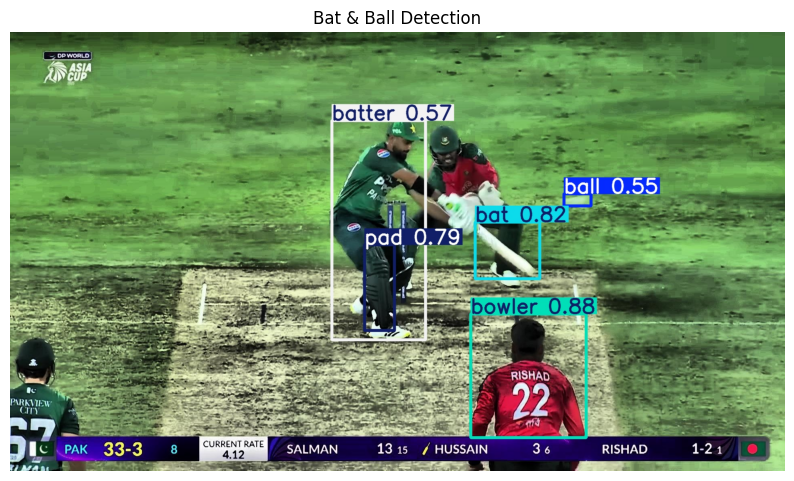

In [12]:
# ✅ Evaluate model performance
metrics = model.val()
print("mAP50:", metrics.box.map50)
print("mAP:", metrics.box.map)

# ✅ Predict on test image
test_image = f"{DATASET_PATH}/test/images/scene06111_jpg.rf.7005b879301ca06511f0a1710afb7b65.jpg"
results = model.predict(source=test_image, conf=0.5, save=True)

# ✅ Display prediction
import cv2, matplotlib.pyplot as plt, os
from glob import glob

predict_dirs = glob("/content/runs/detect/predict*")
latest_pred = max(predict_dirs, key=os.path.getmtime)
pred_path = os.path.join(latest_pred, os.path.basename(test_image))

img = cv2.imread(pred_path)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Bat & Ball Detection")
plt.show()
